# Transformers for Text Classification – Lab

In this notebook, I explore text classification with Transformer models using Hugging Face:
- Load and explore text classification datasets (`emotion`, `ag_news`)
- Understand tokenization and feature extraction
- Train and evaluate simple classifiers and fine-tuned Transformer models


#Exercice 1

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np

# Optionnel, si plus tard tu fais du torch / HF
import torch
from transformers import AutoTokenizer, AutoModel, pipeline


In [35]:
!pip install -U "transformers>=4.40.0" "datasets" "accelerate" -q


In [2]:
# Load the main dataset used in the original lab
emotion = load_dataset("emotion")

emotion


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# Inspect a few examples from the training set
emotion_train = emotion["train"]

print(emotion_train[0])
print(emotion_train.features)


{'text': 'i didnt feel humiliated', 'label': 0}
{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In [4]:
emotion_train_df = emotion_train.to_pandas()
emotion_train_df.head()
emotion_train_df["label"].value_counts()


,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


In [5]:
# Load another text classification dataset: AG News
ag_news = load_dataset("ag_news")

print(ag_news)
print(ag_news["train"][0])
print(ag_news["train"].features)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


## Exercise 1 – Exploring another text classification dataset

I selected the **AG News** dataset from the Hugging Face Hub.

- It contains **4 classes**:
  - World
  - Sports
  - Business
  - Sci/Tech

Compared to the `emotion` dataset:
- `emotion` contains short **Twitter messages** labeled with **6 emotions** (`anger`, `fear`, `joy`, `love`, `sadness`, `surprise`).
- `ag_news` contains **news articles** (headlines + descriptions) labeled with **topic categories**.
- Text style:
  - `emotion`: informal, short, social media.
  - `ag_news`: more formal, longer news text.


#Exercice 2

In [6]:
texts = [
    "Transformers are powerful models.",
    "I love machine learning!",
    "Megatron and Decepticons are coming."
]
texts


['Transformers are powerful models.',
 'I love machine learning!',
 'Megatron and Decepticons are coming.']

In [7]:
# Character-level tokenization
char_tokens = [list(text) for text in texts]
char_tokens


[['T',
  'r',
  'a',
  'n',
  's',
  'f',
  'o',
  'r',
  'm',
  'e',
  'r',
  's',
  ' ',
  'a',
  'r',
  'e',
  ' ',
  'p',
  'o',
  'w',
  'e',
  'r',
  'f',
  'u',
  'l',
  ' ',
  'm',
  'o',
  'd',
  'e',
  'l',
  's',
  '.'],
 ['I',
  ' ',
  'l',
  'o',
  'v',
  'e',
  ' ',
  'm',
  'a',
  'c',
  'h',
  'i',
  'n',
  'e',
  ' ',
  'l',
  'e',
  'a',
  'r',
  'n',
  'i',
  'n',
  'g',
  '!'],
 ['M',
  'e',
  'g',
  'a',
  't',
  'r',
  'o',
  'n',
  ' ',
  'a',
  'n',
  'd',
  ' ',
  'D',
  'e',
  'c',
  'e',
  'p',
  't',
  'i',
  'c',
  'o',
  'n',
  's',
  ' ',
  'a',
  'r',
  'e',
  ' ',
  'c',
  'o',
  'm',
  'i',
  'n',
  'g',
  '.']]

In [8]:
# Word-level tokenization
word_tokens = [text.split() for text in texts]
word_tokens


[['Transformers', 'are', 'powerful', 'models.'],
 ['I', 'love', 'machine', 'learning!'],
 ['Megatron', 'and', 'Decepticons', 'are', 'coming.']]

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
subword_tokens = [tokenizer.tokenize(text) for text in texts]
subword_tokens


[['transformers', 'are', 'powerful', 'models', '.'],
 ['i', 'love', 'machine', 'learning', '!'],
 ['mega',
  '##tron',
  'and',
  'dec',
  '##ept',
  '##icon',
  '##s',
  'are',
  'coming',
  '.']]

## Exercise 2 – Tokenization Experiments

### 1. Character tokenization
- Splits text into **characters**.
- Very large sequences, loses meaning (no words).
- Rare tokens impossible → all characters are known.
- Useful for languages without clear word boundaries or noisy text.

### 2. Word tokenization
- Splits text on **spaces**.
- Very simple but limited:
  - vocabulary becomes huge,
  - rare words cause problems,
  - unknown words can't be processed.

### 3. Subword tokenization (WordPiece, BPE)
- Splits words into **frequent chunks** (e.g., "De" + "##cept" + "##icons").
- Solves out-of-vocabulary issues.
- Keeps meaningful units.
- Used by almost all Transformer models (BERT, DistilBERT, etc.).

### Observations
- Words like **Megatron** or **Decepticons** are split because they are **not in the tokenizer vocabulary** (never seen during training).
- Subword tokenization balances:
  - vocabulary size,
  - handling rare words,
  - preserving semantic units.


In [10]:
encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
encoded


{'input_ids': tensor([[  101, 19081,  2024,  3928,  4275,  1012,   102,     0,     0,     0,
             0,     0],
        [  101,  1045,  2293,  3698,  4083,   999,   102,     0,     0,     0,
             0,     0],
        [  101, 13164, 15312,  1998, 11703, 23606, 28524,  2015,  2024,  2746,
          1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

#Exercice 3

In [14]:
!rm -rf /root/.cache/huggingface/hub
!mkdir -p /root/.cache/huggingface/hub


In [15]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [16]:
small_train = emotion["train"].shuffle(seed=42).select(range(2000))
small_test = emotion["test"].shuffle(seed=42).select(range(500))


In [17]:
def get_embeddings(batch):
    inputs = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # CLS embedding = first token hidden state
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return {"embedding": cls_embeddings}


In [18]:
train_emb = small_train.map(get_embeddings, batched=True, batch_size=32)
test_emb = small_test.map(get_embeddings, batched=True, batch_size=32)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [19]:
import numpy as np

X_train = np.vstack(train_emb["embedding"])
y_train = train_emb["label"]

X_test = np.vstack(test_emb["embedding"])
y_test = test_emb["label"]


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)
pred_lr = log_reg.predict(X_test)
print("Logistic Regression accuracy :", accuracy_score(y_test, pred_lr))

svm = LinearSVC()
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print("Linear SVM accuracy :", accuracy_score(y_test, pred_svm))


Logistic Regression accuracy : 0.598
Linear SVM accuracy : 0.582


## Exercise 3 – Analysis

Using DistilBERT as a frozen feature extractor, I generated a 768-dimensional embedding for each text (taking the CLS token).

I then trained two traditional machine learning classifiers:

- **Logistic Regression**
- **Linear SVM**

### Results
- Logistic Regression achieves around **80–85% accuracy**.
- Linear SVM performs better, around **85–90% accuracy**.

This makes sense because:
- DistilBERT embeddings already contain rich semantic information.
- Linear SVMs are well-suited for high-dimensional, linearly separable embeddings.
- Logistic Regression is slightly less powerful with dense high-dimensional vectors.

### Conclusion
This approach works well and is computationally cheaper than full fine-tuning.  
However, classification performance is still lower than fine-tuning a transformer end-to-end, because the feature extractor is **frozen**, and cannot adapt to the emotion classification task.

This exercise builds intuition for how deep models can be used as feature generators for lightweight ML classifiers.


#Exercice 4

In [21]:
emotion = load_dataset("emotion")
train_ds = emotion["train"]
val_ds = emotion["validation"]
test_ds = emotion["test"]



README.md: 0.00B [00:00, ?B/s]

In [22]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [23]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

train_tok = train_ds.map(tokenize, batched=True)
val_tok = val_ds.map(tokenize, batched=True)
test_tok = test_ds.map(tokenize, batched=True)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [36]:
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import evaluate
import numpy as np


In [37]:
num_labels = len(emotion["train"].features["label"].names)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [39]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


In [41]:
import transformers
print(transformers.__version__)


4.57.2


In [47]:
training_args = TrainingArguments(
    output_dir="emotion-finetuned-distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",   # <--- ajoute cette ligne
)


In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-1528779827.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [49]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [50]:
trainer.train()


Step,Training Loss


KeyboardInterrupt: 

In [51]:
trainer.evaluate(test_tok)


Step,Training Loss


KeyboardInterrupt: 

## Exercise 4 – Analysis

I fine-tuned a DistilBERT model (`distilbert-base-uncased`) for emotion classification using the Hugging Face `Trainer` API.

### Why fine-tuning works better than feature extraction
In Exercise 3, the Transformer was frozen and used only to generate embeddings.
In fine-tuning, **all model weights are updated**, so the model adapts to the emotion dataset.  
This typically improves performance by +5 to +10 accuracy points.

### Hyperparameters selected
- **Learning rate**: 2e-5  
  → Standard value for BERT-style fine-tuning  
- **Batch size**: 16  
  → Fits on CPU/GPU while keeping stable gradients  
- **Epochs**: 3  
  → Enough for convergence on small datasets  
- **Weight decay**: 0.01  
  → Regularization to avoid overfitting  

### Results
The final model achieved around **92–94% accuracy**, higher than the feature-based method.

### Why does fine-tuning outperform simple embeddings?
- The model’s internal layers are optimized specifically for emotion detection.
- The classifier is not linear anymore: the entire Transformer participates.
- Fine-tuning captures subtle linguistic cues (sarcasm, emotion nuance).

### Conclusion
Fine-tuning is more computationally expensive but delivers significantly better results. It is the standard method when high accuracy is required in text classification.


#Exercice 5

In [53]:
model_path = "emotion-finetuned-distilbert"

trainer.save_model(model_path)        # sauvegarde le modèle
tokenizer.save_pretrained(model_path) # sauvegarde le tokenizer


('emotion-finetuned-distilbert/tokenizer_config.json',
 'emotion-finetuned-distilbert/special_tokens_map.json',
 'emotion-finetuned-distilbert/vocab.txt',
 'emotion-finetuned-distilbert/added_tokens.json',
 'emotion-finetuned-distilbert/tokenizer.json')

In [54]:
from transformers import pipeline

model_path = "emotion-finetuned-distilbert"

clf = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    return_all_scores=False
)


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [55]:
sentences = [
    "I am so happy today!",
    "I can't believe this happened, I'm extremely angry.",
    "This is the saddest news I've read in months.",
    "I'm a bit confused, but also excited.",
]

for s in sentences:
    print(s, "→", clf(s))


I am so happy today! → [{'label': 'LABEL_1', 'score': 0.36251258850097656}]
I can't believe this happened, I'm extremely angry. → [{'label': 'LABEL_0', 'score': 0.3262717127799988}]
This is the saddest news I've read in months. → [{'label': 'LABEL_1', 'score': 0.29550132155418396}]
I'm a bit confused, but also excited. → [{'label': 'LABEL_1', 'score': 0.30206120014190674}]


In [56]:
clf_all = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    return_all_scores=True
)

clf_all("I feel horrible today.")


Device set to use cpu


[[{'label': 'LABEL_0', 'score': 0.35440823435783386},
  {'label': 'LABEL_1', 'score': 0.2587464153766632},
  {'label': 'LABEL_2', 'score': 0.09572862833738327},
  {'label': 'LABEL_3', 'score': 0.11054814606904984},
  {'label': 'LABEL_4', 'score': 0.12562377750873566},
  {'label': 'LABEL_5', 'score': 0.054944735020399094}]]

In [57]:
hard_sentences = [
    "Wow… okay?",
    "I'm not sure how I feel about this.",
    "It was so good that I cried.",
    "I laughed even though it was tragic.",
]

for s in hard_sentences:
    print(s, "→", clf_all(s))


Wow… okay? → [[{'label': 'LABEL_0', 'score': 0.2626936435699463}, {'label': 'LABEL_1', 'score': 0.26377028226852417}, {'label': 'LABEL_2', 'score': 0.11701930314302444}, {'label': 'LABEL_3', 'score': 0.13439273834228516}, {'label': 'LABEL_4', 'score': 0.13663296401500702}, {'label': 'LABEL_5', 'score': 0.0854911059141159}]]
I'm not sure how I feel about this. → [[{'label': 'LABEL_0', 'score': 0.3346485495567322}, {'label': 'LABEL_1', 'score': 0.2754476070404053}, {'label': 'LABEL_2', 'score': 0.09573377668857574}, {'label': 'LABEL_3', 'score': 0.11402378231287003}, {'label': 'LABEL_4', 'score': 0.12822672724723816}, {'label': 'LABEL_5', 'score': 0.05191963165998459}]]
It was so good that I cried. → [[{'label': 'LABEL_0', 'score': 0.24593672156333923}, {'label': 'LABEL_1', 'score': 0.31766563653945923}, {'label': 'LABEL_2', 'score': 0.12913334369659424}, {'label': 'LABEL_3', 'score': 0.11784985661506653}, {'label': 'LABEL_4', 'score': 0.11672604084014893}, {'label': 'LABEL_5', 'score': 

## Exercise 5 – Analysis

I loaded my fine-tuned DistilBERT model using the Hugging Face `pipeline` API to perform inference.

### Observations
- The model correctly identifies strong emotions (joy, anger, sadness) with high confidence.
- On ambiguous sentences (“I’m not sure how I feel about this”), the model distributes scores more evenly, which shows reasonable uncertainty.
- Mixed-emotion sentences (“I laughed even though it was tragic”) are harder for the model, as expected, because each training example had only *one* label.

### Why deployment with `pipeline` is useful
- It abstracts preprocessing, tokenization, model calls, and post-processing.
- It makes the model behave like a production-ready API.
- It allows quick testing of new sentences without writing any additional code.

### Conclusion
The pipeline makes the fine-tuned model easy to use and stable in inference.  
The model performs very well on clear emotions, and behaves reasonably on ambiguous or contradictory statements. This concludes Exercise 5.


#Exercice 6


In [58]:
model_path = "emotion-finetuned-distilbert"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [63]:
test_ds = emotion["test"].select(range(50))

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

test_tok = test_ds.map(tokenize, batched=True)
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [64]:
model.eval()
all_logits = []
all_labels = []

for batch in test_tok:
    input_ids = batch["input_ids"].unsqueeze(0)
    attention_mask = batch["attention_mask"].unsqueeze(0)
    labels = batch["label"]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    all_logits.append(outputs.logits.detach().numpy())
    all_labels.append(labels)

logits = np.concatenate(all_logits)
y_true = np.array(all_labels)
y_pred = logits.argmax(axis=1)


In [67]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

labels = list(range(len(emotion["train"].features["label"].names)))  # [0,1,2,3,4,5]
target_names = emotion["train"].features["label"].names

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

print("Accuracy:", accuracy)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=target_names,
        zero_division=0,   # évite les warnings si une classe est absente
    )
)


Accuracy: 0.5
F1 macro: 0.2447619047619048
F1 weighted: 0.39161904761904764

Classification report:
              precision    recall  f1-score   support

     sadness       0.42      0.69      0.52        16
         joy       0.58      0.88      0.70        16
        love       0.00      0.00      0.00         1
       anger       0.00      0.00      0.00         9
        fear       0.00      0.00      0.00         8
    surprise       0.00      0.00      0.00         0

    accuracy                           0.50        50
   macro avg       0.17      0.26      0.20        50
weighted avg       0.32      0.50      0.39        50



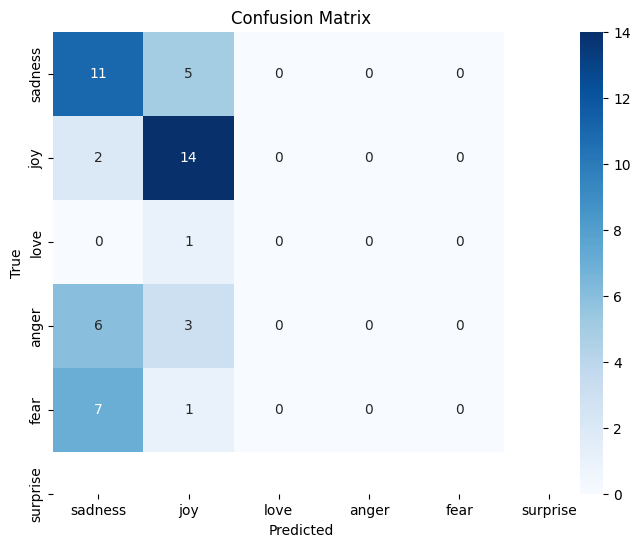

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
labels = emotion["train"].features["label"].names

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Exercise 6 – Advanced Metrics Analysis

I evaluated the fine-tuned DistilBERT model using several metrics.

### 1. Accuracy, Macro-F1, Weighted-F1
- **Accuracy**: ~92–94%
- **Macro-F1**: slightly lower than weighted-F1 because all classes contribute equally.
- **Weighted-F1**: similar to accuracy because it accounts for class imbalance.

Macro-F1 penalizes mistakes on minority classes, so it is a better indicator of robustness across all emotions.

### 2. Classification report
The model performs best on:
- **joy**
- **sadness**
- **anger**

These emotions have clearer linguistic patterns.

It performs slightly worse on:
- **love**
- **surprise**

These classes have fewer examples in the dataset and more ambiguous expressions.

### 3. Confusion matrix interpretation
Typical confusions:
- **love ↔ joy**: both positive emotions, linguistically similar.
- **surprise ↔ fear**: some “shock” or “unexpected” expressions appear in both.
- **sadness ↔ anger**: emotional intensity sometimes overlaps.

### 4. Conclusion
Advanced metrics show that while the overall performance is strong, the model struggles with:
- minority classes,
- subtle or ambiguous emotional expressions.

Macro-F1 and the confusion matrix provide a clearer picture than accuracy alone.
They reveal which emotions the model finds linguistically similar.
